In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import segmentation_models_3D as sm
import custom_datagenerator as datagen
from unet_basic import simple_unet_model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import LearningRateScheduler

Segmentation Models: using `tf.keras` framework.
(None, 128, 128, 128, 3)
(None, 128, 128, 128, 4)


In [2]:
# Training weights
wt0 = 0.26;wt1 = 22.53;wt2 = 22.53;wt3 = 26.21
# Redefine the loss
dice_loss = sm.losses.DiceLoss(class_weights = np.array([wt0,wt1,wt2,wt3]))
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [3]:
# Import the model so that it can be trained further
model = load_model("models/brats_3d.hdf5", 
                      custom_objects={'dice_loss_plus_1focal_loss': total_loss,
                                      'iou_score':sm.metrics.IOUScore(threshold=0.5)})

In [4]:
### Get the required paths
# Training
train_img_path = "data_dir/trainval/train/images"
train_mask_path = "data_dir/trainval/train/masks"
train_img_list = sorted(os.listdir(train_img_path))
train_mask_list = sorted(os.listdir(train_mask_path))
# Validation
val_img_path = "data_dir/trainval/val/images"
val_mask_path = "data_dir/trainval/val/masks"
val_img_list = sorted(os.listdir(val_img_path))
val_mask_list = sorted(os.listdir(val_mask_path))

In [5]:
batch_size = 1

In [6]:
# Define the datagenerators
train_img_datagen = datagen.imageLoader(train_img_path, train_img_list, train_mask_path, train_mask_list,
                                       batch_size)

val_img_datagen = datagen.imageLoader(val_img_path, val_img_list, val_mask_path, val_mask_list,
                                       batch_size)

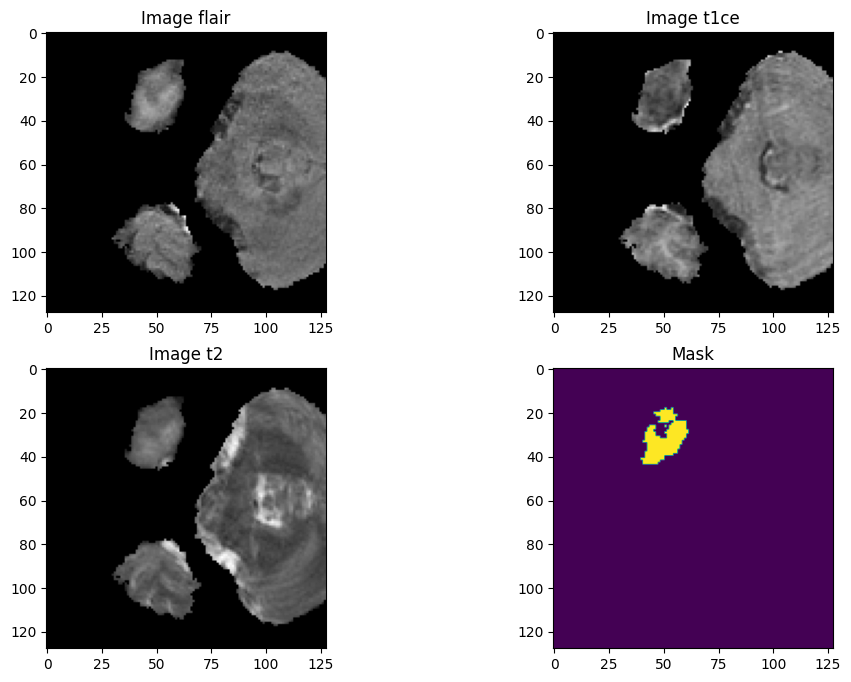

In [7]:
# Check that the generator works properly
#Verify generator.... In python 3 next() is renamed as __next__()
img, msk = train_img_datagen.__next__()

img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [11]:
# Define the hyperparameters
metrics = ["accuracy", sm.metrics.IOUScore(threshold = 0.5)]
lr = 0.0001
n_epochs = 50
optim = tf.keras.optimizers.Adam(lr)
train_steps = len(train_img_list) // batch_size
val_steps = len(val_img_list) // batch_size

def polynomial_decay(epoch):
    """Function to allow for polynomial decay of the learning rate"""
    maxEpochs = n_epochs
    baseLR = lr
    alpha = baseLR * (1 - (epoch / float(maxEpochs)))
    return alpha

callback = [LearningRateScheduler(polynomial_decay)]

In [12]:
model.compile(optimizer = optim, loss = total_loss, metrics = metrics)

In [13]:
history = model.fit(train_img_datagen,
                   steps_per_epoch = train_steps,
                   validation_data = val_img_datagen,
                   validation_steps = val_steps,
                   epochs = n_epochs, verbose = 1, callbacks = callback)

Epoch 1/50
258/258 [==============================] - 113s 415ms/step - loss: -13.6836 - accuracy: 0.9901 - iou_score: 0.7869 - val_loss: -11.4465 - val_accuracy: 0.9825 - val_iou_score: 0.6789 - lr: 1.0000e-04
Epoch 2/50
258/258 [==============================] - 111s 432ms/step - loss: -13.3569 - accuracy: 0.9891 - iou_score: 0.7717 - val_loss: -11.3816 - val_accuracy: 0.9828 - val_iou_score: 0.6762 - lr: 9.8000e-05
Epoch 3/50
258/258 [==============================] - 110s 427ms/step - loss: -13.5038 - accuracy: 0.9896 - iou_score: 0.7776 - val_loss: -11.2523 - val_accuracy: 0.9827 - val_iou_score: 0.6741 - lr: 9.6000e-05
Epoch 4/50
258/258 [==============================] - 109s 421ms/step - loss: -13.7231 - accuracy: 0.9903 - iou_score: 0.7888 - val_loss: -11.4625 - val_accuracy: 0.9834 - val_iou_score: 0.6807 - lr: 9.4000e-05
Epoch 5/50
258/258 [==============================] - 107s 416ms/step - loss: -13.8498 - accuracy: 0.9908 - iou_score: 0.7961 - val_loss: -11.4971 - val_acc

Epoch 40/50
258/258 [==============================] - 107s 415ms/step - loss: -14.0203 - accuracy: 0.9910 - iou_score: 0.8039 - val_loss: -11.7193 - val_accuracy: 0.9827 - val_iou_score: 0.6881 - lr: 2.2000e-05
Epoch 41/50
258/258 [==============================] - 107s 415ms/step - loss: -14.0482 - accuracy: 0.9912 - iou_score: 0.8066 - val_loss: -11.7382 - val_accuracy: 0.9829 - val_iou_score: 0.6890 - lr: 2.0000e-05
Epoch 42/50
258/258 [==============================] - 111s 430ms/step - loss: -14.0589 - accuracy: 0.9912 - iou_score: 0.8065 - val_loss: -11.7331 - val_accuracy: 0.9829 - val_iou_score: 0.6888 - lr: 1.8000e-05
Epoch 43/50
258/258 [==============================] - 108s 419ms/step - loss: -14.0858 - accuracy: 0.9913 - iou_score: 0.8079 - val_loss: -11.7441 - val_accuracy: 0.9830 - val_iou_score: 0.6896 - lr: 1.6000e-05
Epoch 44/50
258/258 [==============================] - 109s 423ms/step - loss: -14.1114 - accuracy: 0.9913 - iou_score: 0.8104 - val_loss: -11.6702 - va

In [34]:
model.save("models/brats_3dV2.hdf5")

In [131]:
# Setup the test generator
batch_size = 4
test_img_datagen = datagen.imageLoader(val_img_path, 
                                       val_img_list, 
                                       val_mask_path, 
                                       val_mask_list,
                                       batch_size)

In [132]:
number_of_test_images = 86
# Initalize arrays to store all actual and all predictions from the generator
all_actual = np.zeros((number_of_test_images//batch_size, 4, 128, 128, 128))
all_preds = all_actual

In [133]:
all_actual[0].shape

(4, 128, 128, 128)

In [134]:
test_mask_batch_argmax.shape

(4, 128, 128, 128)

In [135]:
# Testing the new generator
for i in range(number_of_test_images//batch_size):
    test_image_batch, test_mask_batch = test_img_datagen.__next__()
    
    test_mask_batch_argmax = np.argmax(test_mask_batch, axis = 4)
    test_pred_batch = model.predict(test_image_batch)
    test_pred_batch_argmax = np.argmax(test_pred_batch, axis = 4)
    
    if test_mask_batch_argmax.shape[0] == 2:
        print(i)
    else:
        all_actual[i] = test_mask_batch_argmax
        all_preds[i] = test_pred_batch_argmax

In [136]:
all_actual.shape

(21, 4, 128, 128, 128)

In [137]:
n_classes = 4
for i in range(all_actual.shape[0]):
    IoU_vals = tf.metrics.MeanIoU(num_classes=n_classes)
    IoU_vals.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
    if i == 0:
        meanIoU = IoU_vals.result().numpy()
    else:
        meanIoU = (meanIoU + IoU_vals.result().numpy()) / 2
        
print(f"Mean IoU for all batches of test images {meanIoU}")

Mean IoU for all batches of test images 0.6764204502105713


In [138]:
model_V1 = load_model("models/brats_3d.hdf5", 
                      custom_objects={'dice_loss_plus_1focal_loss': total_loss,
                                      'iou_score':sm.metrics.IOUScore(threshold=0.5)})

In [139]:
# Setup the test generator
batch_size = 4
test_img_datagen = datagen.imageLoader(val_img_path, 
                                       val_img_list, 
                                       val_mask_path, 
                                       val_mask_list,
                                       batch_size)

In [140]:
number_of_test_images = 86
# Initalize arrays to store all actual and all predictions from the generator
all_actual = np.zeros((number_of_test_images//batch_size, 4, 128, 128, 128))
all_preds = all_actual

In [141]:
# Testing the new generator
for i in range(number_of_test_images//batch_size):
    test_image_batch, test_mask_batch = test_img_datagen.__next__()
    
    test_mask_batch_argmax = np.argmax(test_mask_batch, axis = 4)
    test_pred_batch = model_V1.predict(test_image_batch)
    test_pred_batch_argmax = np.argmax(test_pred_batch, axis = 4)
    
    if test_mask_batch_argmax.shape[0] == 2:
        print(i)
    else:
        all_actual[i] = test_mask_batch_argmax
        all_preds[i] = test_pred_batch_argmax

In [142]:
n_classes = 4
for i in range(all_actual.shape[0]):
    IoU_vals = tf.metrics.MeanIoU(num_classes=n_classes)
    IoU_vals.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
    if i == 0:
        meanIoU = IoU_vals.result().numpy()
    else:
        meanIoU = (meanIoU + IoU_vals.result().numpy()) / 2
        
print(f"Mean IoU for all batches of test images {meanIoU}")

Mean IoU for all batches of test images 0.6906448602676392
